<a href="https://colab.research.google.com/github/euguroglu/Machine-Learning-Projects/blob/master/Fraud_detection_unsupervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [1]:
%tensorflow_version 2.x

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loadind data

In [8]:
data = pd.read_csv("310_23498_bundle_archive.zip")
data.shape

(284807, 31)

In [9]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [10]:
data.groupby(['Class']).count()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315
1,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492


## Normalizing data

In [11]:
data = data.drop(['Time'], axis=1) #Also we dont required Time data
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1)) 

## Auto Encoder data preperation

In [12]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=0) #Data split between train and test set
X_train = X_train.drop(['Class'], axis=1) #Class is not required in train data set since it is label data
y_test = X_test['Class'] #specifying label data set for prediction
X_test = X_test.drop(['Class'], axis=1) #same class is not required in test data set
X_train = X_train.values #changing dataframe into array
X_test = X_test.values #changing dataframe into array
X_train.shape

(227845, 29)

## Autoencoder Model

Below is standart model for autoencoder with 4 layers

In [ ]:
input_dim = X_train.shape[1]
encoding_dim = 20

model = Sequential()
model.add(Dense(encoding_dim, activation="relu", input_shape=(input_dim,)))
model.add(Dense(int(encoding_dim / 2), activation="relu"))
model.add(Dense(int(encoding_dim / 2), activation='relu'))
model.add(Dense(input_dim, activation='relu'))

model.summary()

In [14]:
nb_epoch = 40
batch_size = 32

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])

history = model.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    validation_data=(X_test, X_test),
                    verbose=1)

autoencoder = model

Epoch 1/40
7121/7121 [==============================] - 9s 1ms/step - loss: 0.8239 - acc: 0.6117 - val_loss: 0.7814 - val_acc: 0.7145
Epoch 2/40
7121/7121 [==============================] - 9s 1ms/step - loss: 0.7562 - acc: 0.7315 - val_loss: 0.7560 - val_acc: 0.7510
Epoch 3/40
7121/7121 [==============================] - 9s 1ms/step - loss: 0.7373 - acc: 0.7594 - val_loss: 0.7401 - val_acc: 0.7669
Epoch 4/40
7121/7121 [==============================] - 9s 1ms/step - loss: 0.7294 - acc: 0.7681 - val_loss: 0.7380 - val_acc: 0.7724
Epoch 5/40
7121/7121 [==============================] - 9s 1ms/step - loss: 0.7263 - acc: 0.7729 - val_loss: 0.7364 - val_acc: 0.7686
Epoch 6/40
7121/7121 [==============================] - 9s 1ms/step - loss: 0.7244 - acc: 0.7720 - val_loss: 0.7351 - val_acc: 0.7698
Epoch 7/40
7121/7121 [==============================] - 9s 1ms/step - loss: 0.7231 - acc: 0.7750 - val_loss: 0.7326 - val_acc: 0.7795
Epoch 8/40
7121/7121 [==============================] - 9s 1ms

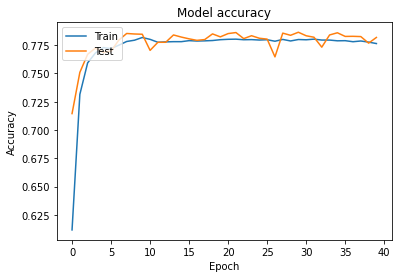

In [15]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Prediction

Predictions are made on the test set. The mean-squared error (MSE) is calculated between the test set and their predictions. If the MSE is high, it's a potential irregularity that might suggest fraud. It's not perfect, there will be false positives and false negatives.

In [16]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})

In [21]:
error_df.head()

,reconstruction_error,true_class
183484,0.290310,0
255448,0.225183,0
244749,1.047568,0
63919,0.541144,0
11475,0.694220,0


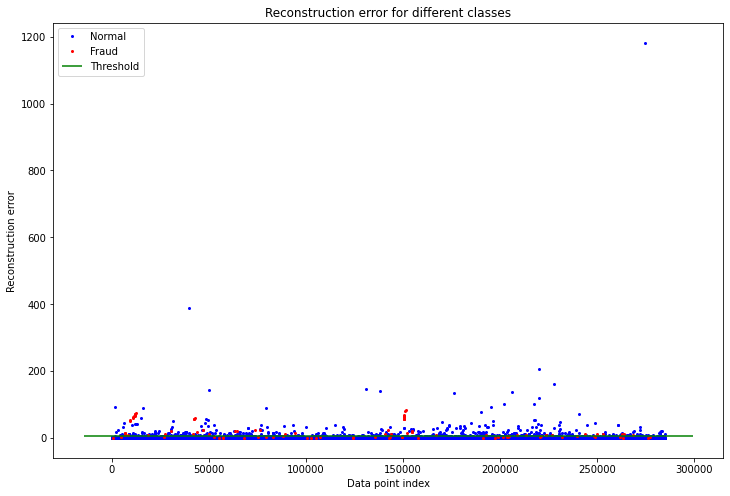

In [34]:
threshold = 6.0

groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(12, 8))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=2.0, linestyle='',
            label = "Fraud" if name == 1 else "Normal",
            color = "red" if name == 1 else "blue")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="green", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [38]:
normal = error_df[error_df.true_class == 0]
fraud = error_df[error_df.true_class == 1]

print('Normal transactions: %d, fraud transactions: %d' % (len(normal), len(fraud)))

Normal transactions: 56861, fraud transactions: 101


In [39]:
true_positives = len(fraud[fraud.reconstruction_error >= threshold])
false_positives = len(normal[normal.reconstruction_error >= threshold])

true_negatives = len(normal[normal.reconstruction_error < threshold])
false_negatives = len(fraud[fraud.reconstruction_error < threshold])

print('True positives: %d, true negatives: %d' % (true_positives, true_negatives))
print('False positives: %d, false negatives: %d' % (false_positives, false_negatives))

True positives: 61, true negatives: 56297
False positives: 564, false negatives: 40


## Confusion matrix

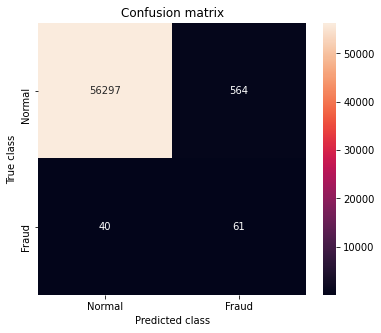

In [40]:
labels = ["Normal", "Fraud"]

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()